In [52]:
import numpy as np
import matplotlib.pyplot as plt
from pymc3 import Normal, Model, HalfNormal, Uniform, Deterministic, sample, sample_prior_predictive, math, plot_trace
from pymc3_ext.distributions import Angle
from astropy.io import ascii
from astropy.time import Time
import astropy.units as u
from chromatic import *
import astrotools.orbitparams as orb

In [2]:
sample = ascii.read('sample_final.csv')

In [3]:
targind = np.argwhere(sample['pl_name']=='HD 260655 b')
targ = sample[targind]
targ

hostname,pl_name,sy_dist,rastr,decstr,sy_kmag,st_mass,st_rad,st_raderr1,st_raderr2,st_teff,pl_tranmid,pl_tranmiderr1,pl_tranmiderr2,pl_rade,pl_radeerr1,pl_radeerr2,pl_bmasse,pl_bmasseerr1,pl_bmasseerr2,pl_orbper,pl_orbpererr1,pl_orbpererr2,pl_orbsmax,pl_orbincl,pl_orbeccen,pl_orbeccenerr1,pl_orbeccenerr2,tran_flag,rv_flag,pl_rp_rs,pl_g,pl_teq_a0,pl_s,filter,subarray,nobs
str9[1],str11[1],float64[1],str12[1],str13[1],float64[1],float64[1],float64[1],float64[1],float64[1],float64[1],float64[1],float64[1],float64[1],float64[1],float64[1],float64[1],float64[1],float64[1],float64[1],float64[1],float64[1],float64[1],float64[1],float64[1],float64[1],float64[1],float64[1],int64[1],int64[1],float64[1],float64[1],float64[1],float64[1],str6[1],str6[1],int64[1]
HD 260655,HD 260655 b,10.0055,06h37m09.97s,+17d33m58.57s,5.862,0.44,0.439,0.003,-0.003,3803.0,2459497.9102,0.0003,-0.0003,1.24,0.023,-0.023,2.14,0.34,-0.34,2.76953,3e-05,-3e-05,0.02933,87.35,0.039,0.043,-0.023,1,1,0.02589563026767422,13.63720864077306,709.4729664292033,42.072735108287475,f1500w,sub256,1


In [76]:
P_mu    = targ['pl_orbper'].value[0][0]
P_sig   = np.mean([targ['pl_orbpererr1'], abs(targ['pl_orbpererr2'])])
Tc_mu   = targ['pl_tranmid'].value[0][0]
Tc_sig  = np.mean([targ['pl_tranmiderr1'], abs(targ['pl_tranmiderr2'])])
e_guess = targ['pl_orbeccen'].value[0][0] + targ['pl_orbeccenerr1'].value[0][0]
e_guess

0.08199999999999999

Make sure that the propagated mid-time from the ephemeris is still small:

In [77]:
# picking an orbit number in the near future
orbit_number = np.median(np.round((Time('2023-12-01').jd - from_paper['Tc'])/from_paper['P']))
predicted_transit_time = from_paper['P']*orbit_number + from_paper['Tc']
print(f'The uncertainty on predicted transit times in 2023 = {np.std(predicted_transit_time)*24*60} minutes')

The uncertainty on predicted transit times in 2023 = 12.15506785039576 minutes


In [78]:
assumptions = {}
Nsamp = 10000

In [79]:
with Model() as model:
    P = Normal('P', mu=P_mu, sigma=P_sig)
    Tc = Normal('Tc', mu=Tc_mu, sigma=Tc_sig)
    e = HalfNormal('e', sigma=e_guess/2)
    w = Uniform('w', -np.pi, np.pi)
    ecosw = Deterministic('ecosw', e*math.cos(w))
    dt = Deterministic('dt', P/2*(4/np.pi*ecosw))
    from_paper = sample_prior_predictive(Nsamp)
assumptions[f'Literature RV measurement $e={e_guess}$ (95%) and uniform $\omega$'] = from_paper

In [80]:
len(assumptions)

1

In [94]:
tdur = orb.Tdur(P=targ['pl_orbper']*u.day, 
                Rp_Rs=((targ['pl_rade']*u.R_earth)/(targ['st_rad']*u.R_sun)).decompose(),
                a_Rs = ((targ['pl_orbsmax']*u.AU)/(targ['st_rad']*u.R_sun)).decompose(),
                i = targ['pl_orbincl']
               )[0][0] # event duration
print('event duration:', tdur.to(u.hour))
t_settle = 0.5*u.hour
t_eclipse = tdur.to(u.hour)
t_flexibility = 1*u.hour
t_out_of_eclipse = t_eclipse*1
t_extra = 1.5*u.hour


windows = {}
duration_without_extra = (t_settle + t_eclipse + t_out_of_eclipse + t_flexibility)
start, stop = (-duration_without_extra/2).value, (duration_without_extra/2).value
windows[f'without extra'] = start, stop
#start, stop = (-duration_without_settle/2 - t_settle).value, (duration_without_settle/2).value
#windows[f'with settling {t_settle:.1f}'] = start, stop
duration_with_extra = duration_without_extra + t_extra
start, stop = (-duration_with_extra/2).value, (duration_with_extra/2).value
windows[f'with extra {t_extra:.1f}'] = start, stop

event duration: 1.1532108714669438 h



With the assumption of
'Literature RV measurement $e=0.08199999999999999$ (95%) and uniform $\omega$',
and the 
'without extra' 
observing window option, 
The best offset from exactly 0.5 phase is -0.08 hours.
the mid-eclipse time should fall within the average post-settling 
observing window with a probability of 87.42%.
Averaged over allowed windows, the mid-eclipse should fall within 
this window with a probability of 86.66% +/- 0.58%
        

With the assumption of
'Literature RV measurement $e=0.08199999999999999$ (95%) and uniform $\omega$',
and the 
'with extra 1.5 h' 
observing window option, 
The best offset from exactly 0.5 phase is -0.08 hours.
the mid-eclipse time should fall within the average post-settling 
observing window with a probability of 95.04%.
Averaged over allowed windows, the mid-eclipse should fall within 
this window with a probability of 94.79% +/- 0.25%
        


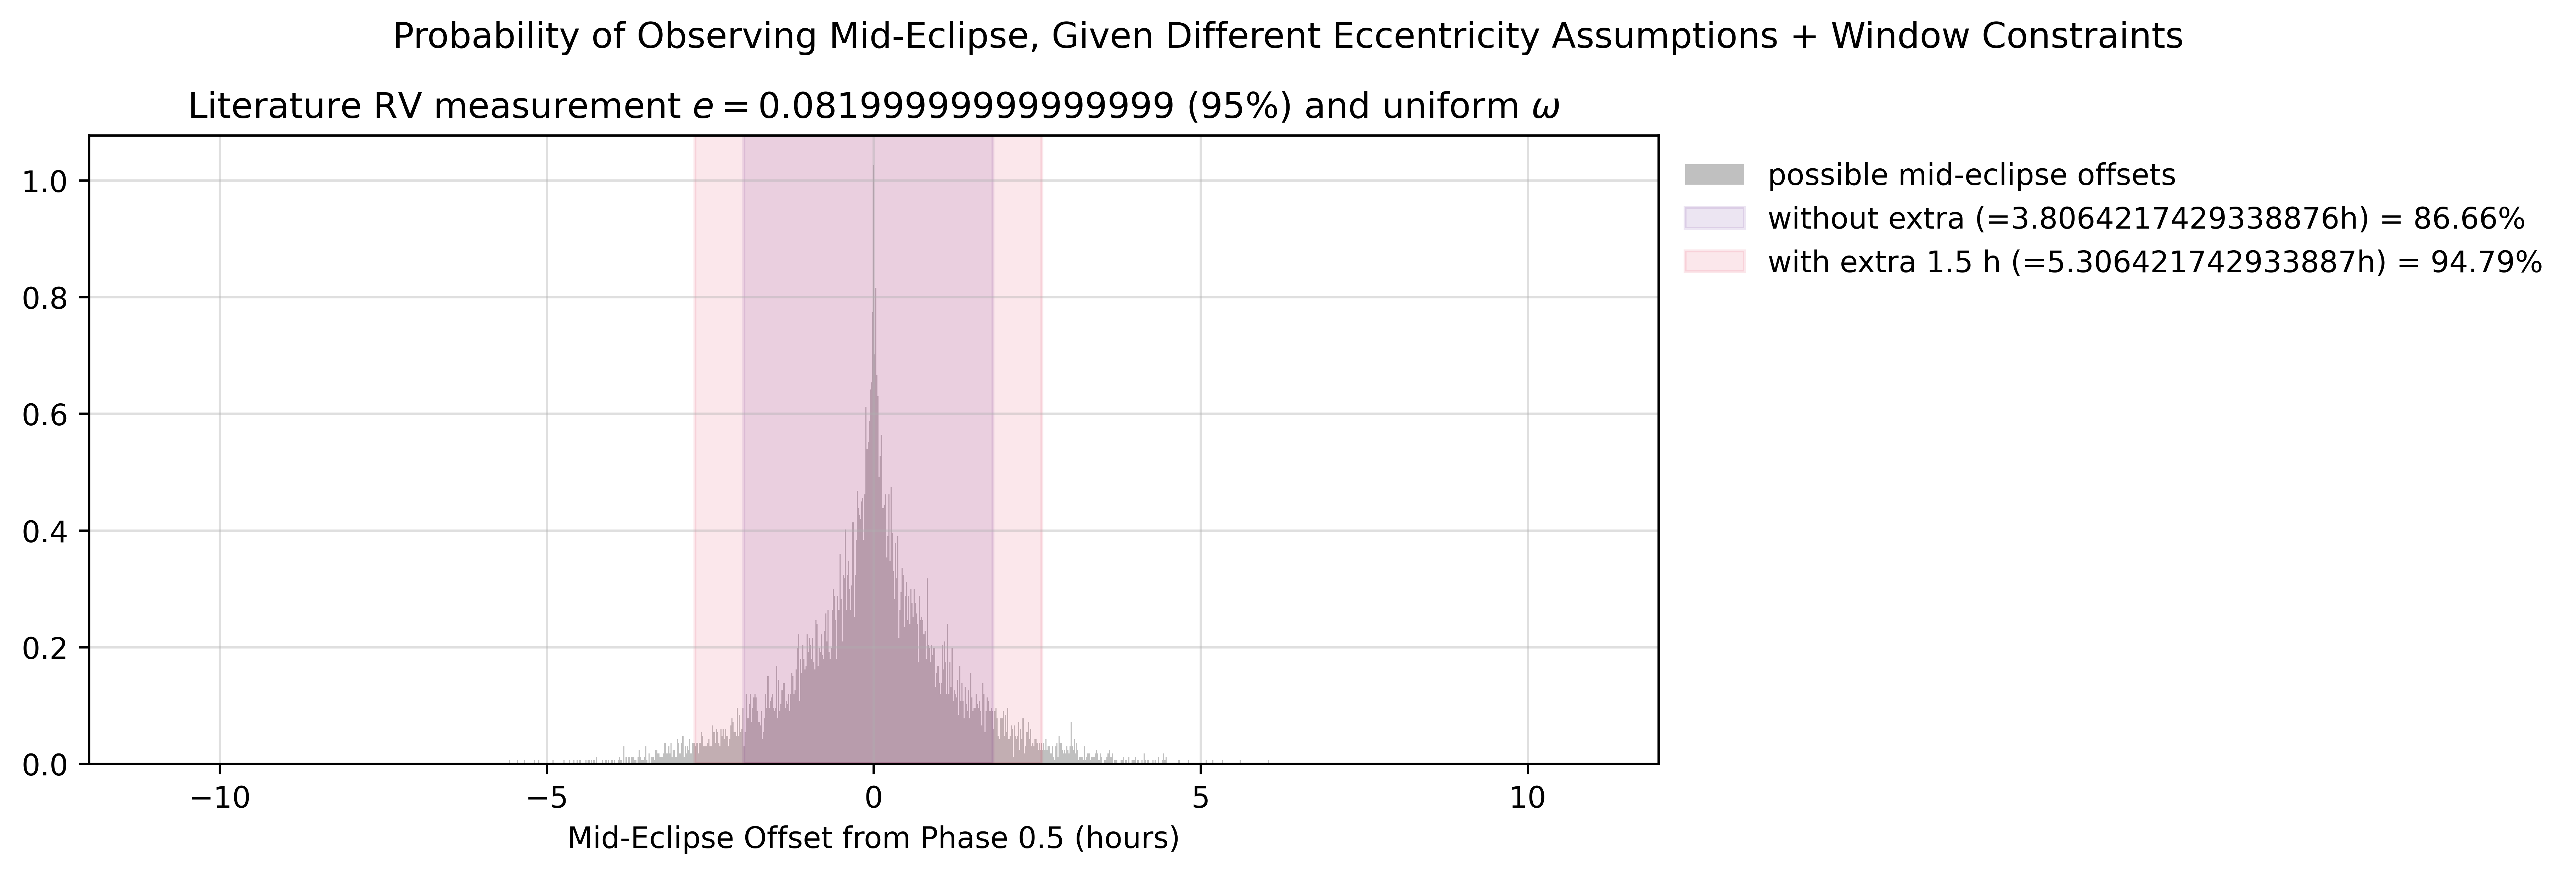

In [95]:
fi, ax = plt.subplots(len(assumptions), 1, figsize=(12, 4*len(assumptions)), constrained_layout=True, dpi=600)
if len(assumptions)==1: ax=[ax]
for (t, d), a in zip(assumptions.items(), ax):
    dt_hours = d['dt']*24
    plt.sca(a)
    plt.hist(dt_hours, bins=np.linspace(-24,24,48*60), density=True, label='possible mid-eclipse offsets', color='silver');
    
    for (label, (start, stop)), color in zip(windows.items(), ['indigo', 'crimson', 'orangered', 'gold']):
        best_offset_from_zero = 0
        fraction_within_exact = 0 
        for offset_from_zero in np.linspace(-4,4):
            this_fraction_within_exact = np.sum((dt_hours >= (start + offset_from_zero))  & (dt_hours <= (stop + offset_from_zero)))/len(dt_hours)
            if this_fraction_within_exact > fraction_within_exact:
                best_offset_from_zero = offset_from_zero
                fraction_within_exact = this_fraction_within_exact       
        start += best_offset_from_zero
        stop += best_offset_from_zero
        fractions_within_possible = []
        for i in range(100):
            nudge = np.random.uniform(-t_flexibility.value/2, t_flexibility.value/2)
            possible_start, possible_stop = start + nudge, stop + nudge 
            f = np.sum((dt_hours >= possible_start)  & (dt_hours <= possible_stop))/len(dt_hours)
            fractions_within_possible.append(f)
        average_fraction = np.mean(fractions_within_possible)
        sigma_fraction = np.std(fractions_within_possible)
        print(f"""
With the assumption of
'{t}',
and the 
'{label}' 
observing window option, 
The best offset from exactly 0.5 phase is {best_offset_from_zero:.2f} hours.
the mid-eclipse time should fall within the average post-settling 
observing window with a probability of {fraction_within_exact:.2%}.
Averaged over allowed windows, the mid-eclipse should fall within 
this window with a probability of {average_fraction:.2%} +/- {sigma_fraction:.2%}
        """)    
        plt.axvspan(start, stop, alpha=0.1, color=color, label=label + f' (={stop-start}h) = {average_fraction:.2%}')

    plt.title(t)
    plt.legend(frameon=False, bbox_to_anchor=(1,1))
    plt.xlim(-12, 12)
    plt.grid(alpha=0.4)
    plt.xlabel('Mid-Eclipse Offset from Phase 0.5 (hours)')
plt.suptitle('Probability of Observing Mid-Eclipse, Given Different Eccentricity Assumptions + Window Constraints');
#plt.savefig('ltt1445Ab-eclipse-timing-constraints.png')

!! need to adjust based on skewed uncertainty in eccentricity; don't have distribution so need to measure one side, then the other... then make sure to add each to the correct side